In [1]:
import os
import sys

os.chdir("..")
sys.path.append("..")

In [2]:
import yaml
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import TrainDataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.time_feature import (
    HourOfDay,
    DayOfWeek,
    DayOfMonth,
    DayOfYear,
    MonthOfYear
)
from gluonts.torch.batchify import batchify
from gluonts.transform import (
    AddObservedValuesIndicator,
    AddTimeFeatures,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm

from src.app.utils import get_prediction_dataloader
from src.models.utils import get_model
from src.utils.data_loading import load_features, load_score, load_test_data
from src.utils.evaluation import score_batch
from src.utils.features import trend_determination, trend_slope, trend_linearity, seasonal_determination, decomps_and_features
from src.utils.transformations import manipulate_trend_component, manipulate_seasonal_determination

/home/hakon/anaconda3/envs/whatif/lib/python3.7/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [3]:
model_name = "nbeats_g"
dataset = "electricity_nips"

datadir = f"data/{dataset}"
experiment_dir = f"experiments/{dataset}/{model_name}"
generated_datadir = os.path.join(datadir, "generated", "test")
metric = "mase"

In [4]:
with open(os.path.join(experiment_dir, "config.yaml"), "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(config["model_name"])(**config["model_args"], device=device, path=config["path"])
model.load_state_dict(torch.load(os.path.join(config["path"], "model.pth")))

<All keys matched successfully>

In [5]:
score = load_score(experiment_dir, metric)
score.shape

(2590, 24)

In [6]:
def load_generated_data(feature_prefix, generated_test_datadir, len_test_data):
    features = [0 for _ in range(len_test_data)]
    for f in os.listdir(generated_test_datadir):
        if f.startswith(feature_prefix):
            file_name = f.split(".")[0]  # slice off .npy from file name
            ts_idx = int(file_name[len(feature_prefix):])  # the remaining charachters after prefix is always the time series id
            features[ts_idx] = np.load(os.path.join(generated_test_datadir, f))

    features = np.array(features)  # [len(original_test), num_manipulations, 4]
    return features

### Can we use the already generated data to find out of distribution samples and use those as testing?

In [7]:
feature_prefix = "feat_seasonal_str"

gen_features = load_generated_data(feature_prefix, generated_datadir, score.shape[0])
gen_features = gen_features.reshape([-1, 4])  # flatten the two first dimensions
gen_features.shape

(512820, 4)

In [8]:
train_features = load_features(datadir, train=True)
test_features = load_features(datadir, train=False)
train_features.shape, test_features.shape

((25600, 4), (2590, 4))

In [9]:
scaler = StandardScaler()
norm_train_features = scaler.fit_transform(train_features)
norm_test_features = scaler.transform(test_features)
norm_gen_features = scaler.transform(gen_features)

pca = PCA(n_components=2)
train_pca_data = pca.fit_transform(norm_train_features)
test_pca_data = pca.transform(norm_test_features)
gen_pca_data = pca.transform(norm_gen_features)

(-4.0, 9.0)

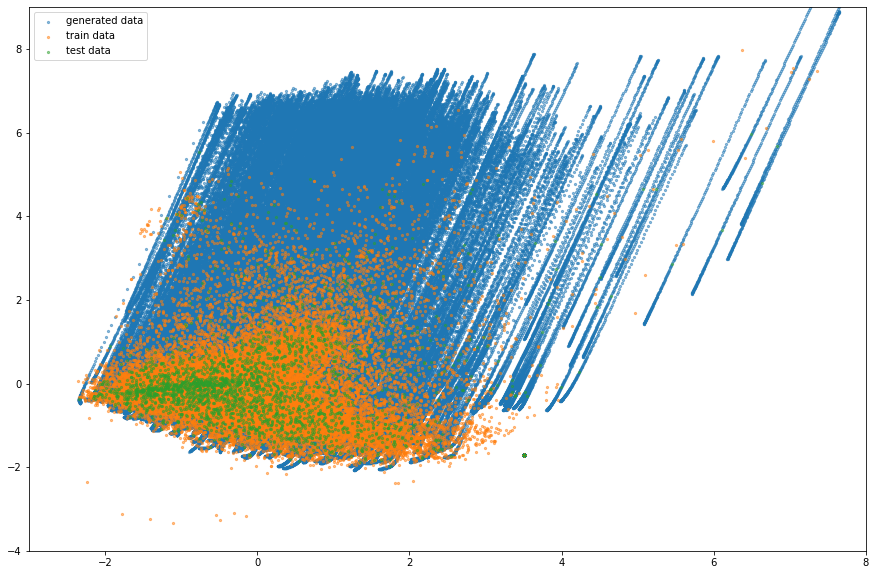

In [10]:
plt.figure(figsize=(15, 10))

plt.scatter(gen_pca_data[:, 0], gen_pca_data[:, 1], label="generated data", s=5, alpha=0.5)
plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=0.5)
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=0.5)
plt.legend()
plt.xlim([-3, 8])
plt.ylim([-4, 9])

By looking at the placement of the generated data it seems like it might be akward to use that directly. This kind of makes sense as they are only transformed in one dimension at the time. Thus, we should try to create new data by transforming multiple features at once targeting specific areas in the PCA-space.

## Transforming time series in mutliple dimensions, targeting specific areas in PCA-space

TODO:
<ul>
  <li><strike>sample time series around in an area</strike></li>
  <li>evaluate method on samples time series</li>
  <li>create training samples, retrain and retest</li>
  <li>decide which metric to use, MASE gives the most obvious signal for non-seasonal data</li>
</ul>
      
interesting places to sample:
<ul>
    <li>(5, 4) is an area with large nonlinear trend components and small seasonal components</li>
    <li>[(1.5, -3.5), (4.0, -1.0)] is an area with that exibit both strong linear trends with slopes, and a strong seasonal component</li>
</ul>

### Sample time series by setting the trend linearity to 10 and a random slope in [-1, 1]

In [11]:
def evaluate_on_generated_data(generated_data, freq, context_length, prediction_length):
    dataset = ListDataset([{"start": ts.index[0], "target": ts.values, "feat_static_cat": np.array([i])} for i, ts in enumerate(generated_data)], freq=freq)
    dataloader = get_prediction_dataloader(dataset, context_length, prediction_length)

    mape = []
    smape = []
    mase = []
    seasonal_mase = []
    mse = []
    model.eval()
    for batch in tqdm(dataloader):
        predictions = model.predict(batch)[:, :, 0]

        context = batch["past_target"].unsqueeze(dim=-1).numpy()
        target = batch["future_target"].numpy()
        scores = score_batch(target, predictions, context, config["sp"])

        mape.append(scores[0])
        smape.append(scores[1])
        mase.append(scores[2])
        seasonal_mase.append(scores[3])
        mse.append(scores[4])

    mape = np.vstack(mape)
    smape = np.vstack(smape)
    mase = np.vstack(mase)
    seasonal_mase = np.vstack(seasonal_mase)
    mse = np.vstack(mse)
    
    return mape, smape, mase, seasonal_mase, mse

In [12]:
def sample_and_plot_pca(dataset, sp, freq, context_length, prediction_length, scaler, pca, func, func_args, num_iterations):
    test_data = load_test_data(dataset)
    
    generated_data = []
    generated_features = []
    for i in range(num_iterations):
        iteration_data, iteration_features = func(test_data, **func_args)
        generated_data.extend(iteration_data)
        generated_features.append(iteration_features)
    
    generated_features = np.vstack(generated_features)
    
    norm_new_features = scaler.transform(generated_features)
    new_pca_data = pca.transform(norm_new_features)

    plt.figure(figsize=(15, 10))
    plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=.1)
    plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.1)
    plt.scatter(new_pca_data[:, 0], new_pca_data[:, 1], label="new generated", s=5, alpha=1)
    plt.legend()
    plt.xlim([-3, 8])
    plt.ylim([-4, 9])
    
    metrics = evaluate_on_generated_data(generated_data, freq, context_length, prediction_length)

    return generated_data, generated_features, metrics

In [13]:
def plot_generated_samples(generated_data):
    fig, rows = plt.subplots(10, 10, figsize=(20, 20))
    rng = np.random.default_rng()
    
    sampled_indexes = rng.choice(np.arange(len(generated_data)), replace=False, size=100)
    num_plots = 0
    for col in rows:
        for ax in col:
            idx = sampled_indexes[num_plots]
            ax.plot(generated_data[idx])
            ax.set_xticks([])
            ax.set_yticks([])
            num_plots += 1

In [14]:
def sample_slope(test_data, slope_min, slope_max, f, g, h, sp):
    rng = np.random.default_rng()
    generated = []
    features = np.zeros((len(test_data), 4))
    for i, ts in tqdm(enumerate(test_data)):
        decomp = STL(ts, period=sp).fit()
        slope = rng.uniform(low=slope_min, high=slope_max) / len(ts)  # we define it as a % increase per time series length
        sampled_trend = manipulate_trend_component(decomp.trend, f=f, g=g, h=h, m=slope)
        new_ts = sampled_trend + decomp.seasonal + decomp.resid
        generated.append(new_ts)

        decomp = STL(new_ts, period=sp).fit()
        features[i, 0] = trend_determination(decomp.trend, decomp.resid)
        features[i, 1] = trend_slope(decomp.trend)
        features[i, 2] = trend_linearity(decomp.trend)
        features[i, 3] = seasonal_determination(decomp.seasonal, decomp.resid)
    
    return generated, features

  0%|          | 0/2590 [00:00<?, ?it/s]

Loading test data


100%|██████████| 2590/2590 [00:02<00:00, 882.74it/s]
2590it [00:50, 51.22it/s]
41it [00:04,  9.02it/s]


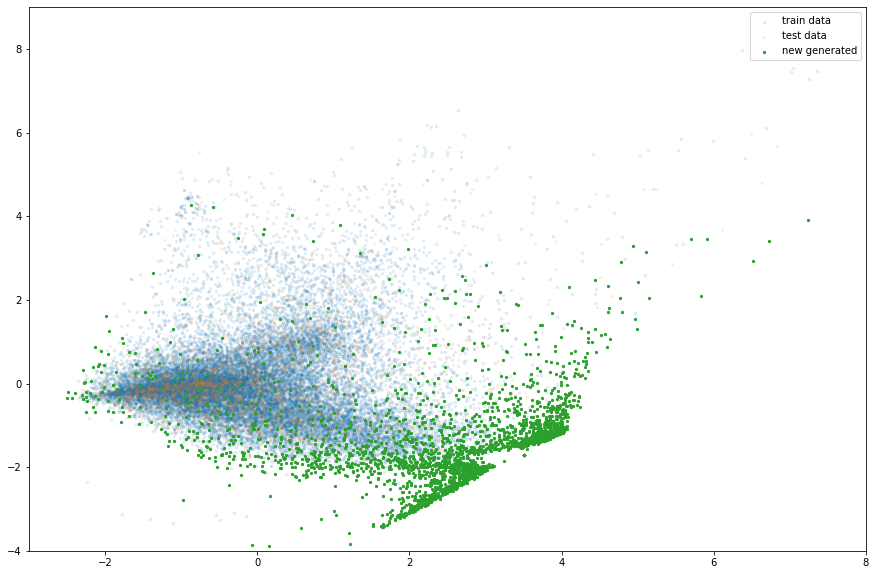

In [15]:
num_iterations = 1

sp = 24
func_args = dict(
    sp = sp,
    slope_min = -1,
    slope_max = 1,
    f = 1,  # trend strength
    g = 1,  # multiplier of the trend slope 
    h = 10  # trend lin
)

generated_data, generated_features, generated_metrics  = sample_and_plot_pca(dataset, sp, "H", config["context_length"], config["prediction_length"], scaler, pca,
                                                                             sample_slope, func_args, num_iterations)

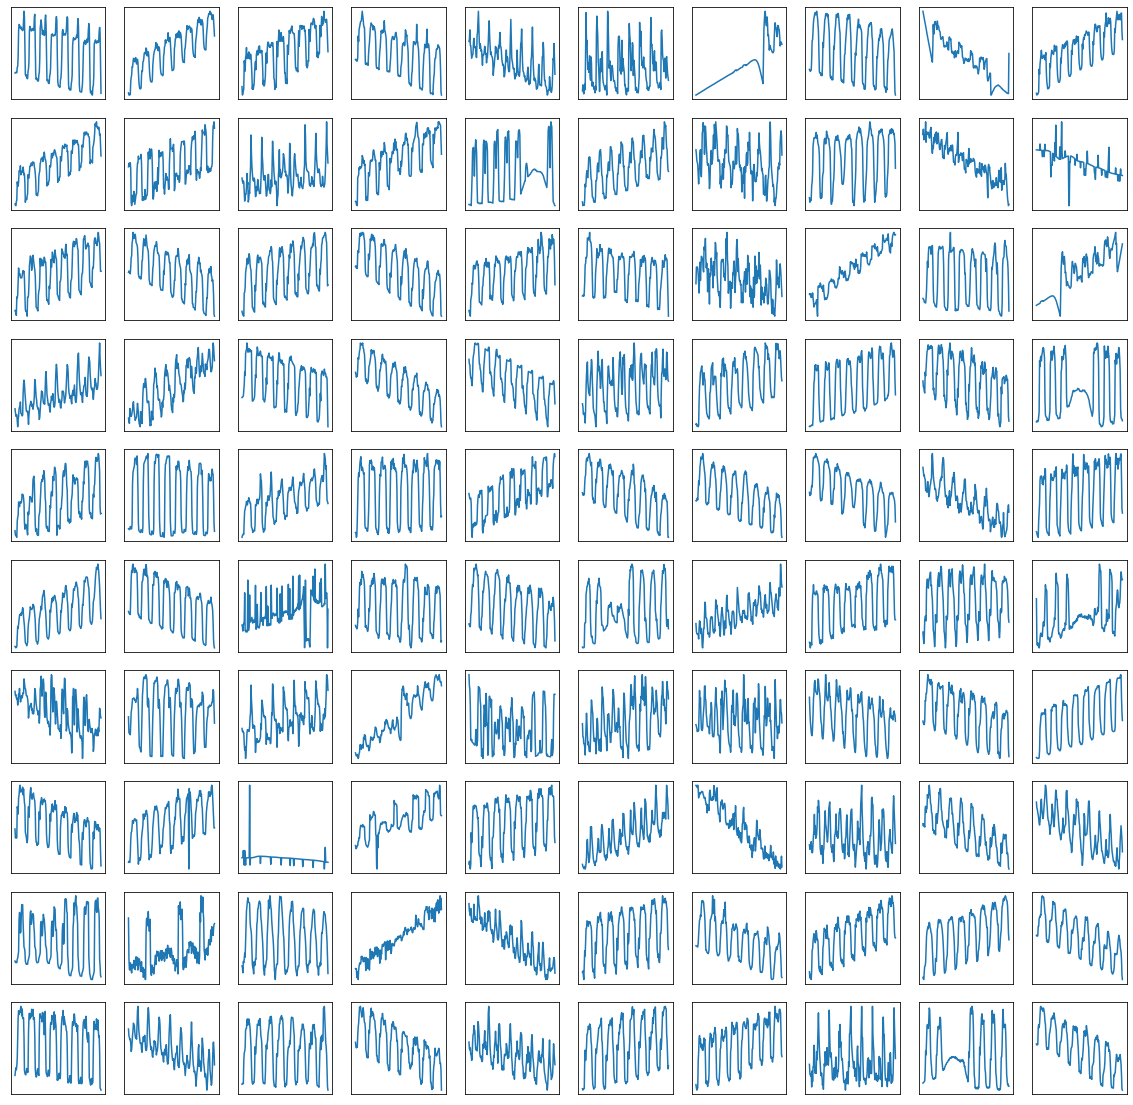

In [16]:
plot_generated_samples(generated_data)

### Sample time series with strong, linear trends and little seasonality

In [17]:
def sample_trends_and_seasonality(test_data, f_min, f_max, g, h_min, h_max, m, k_min, k_max, sp):
    rng = np.random.default_rng()
    generated = []
    features = np.zeros((len(test_data), 4))
    for i, ts in tqdm(enumerate(test_data)):
        decomp = STL(ts, period=sp).fit()
        
        f = rng.uniform(low=f_min, high=f_max)
        h = rng.uniform(low=h_min, high=h_max)
        k = rng.uniform(low=k_min, high=k_max)
        
        sampled_trend = manipulate_trend_component(decomp.trend, f=f, g=g, h=h, m=m)
        sampled_seasonal = manipulate_seasonal_determination(decomp.seasonal, k=k)
        new_ts = sampled_trend + sampled_seasonal + decomp.resid
        generated.append(new_ts)

        decomp = STL(new_ts, period=sp).fit()
        features[i, 0] = trend_determination(decomp.trend, decomp.resid)
        features[i, 1] = trend_slope(decomp.trend)
        features[i, 2] = trend_linearity(decomp.trend)
        features[i, 3] = seasonal_determination(decomp.seasonal, decomp.resid)
    
    return generated, features

  0%|          | 0/2590 [00:00<?, ?it/s]

Loading test data


100%|██████████| 2590/2590 [00:02<00:00, 872.55it/s]
2590it [00:51, 50.10it/s]
41it [00:04,  8.80it/s]


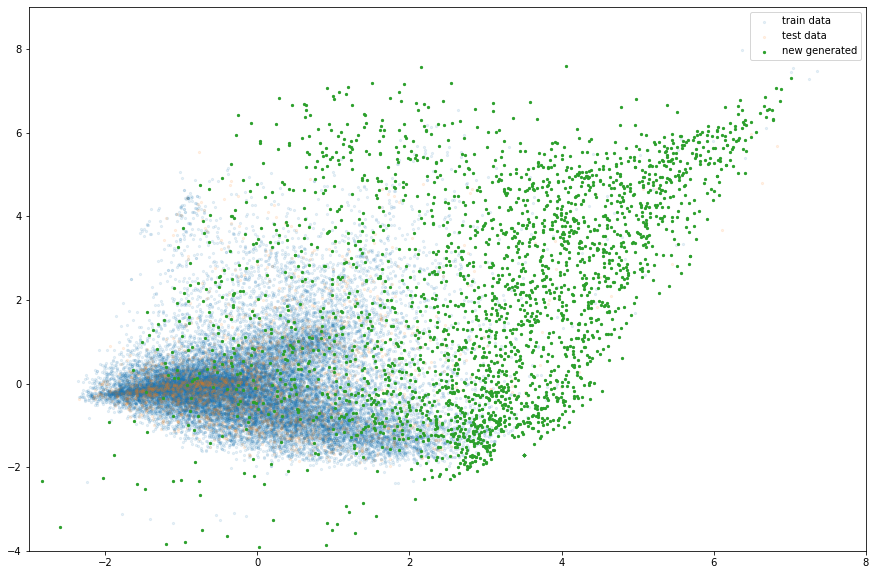

In [18]:
num_iterations = 1

sp = 24
func_args = dict(
    sp = sp,
    f_min = 5,  # trend strength
    f_max = 10,
    g = 1,  # multiplier of the trend slope 
    h_min = 5,  # trend lin
    h_max = 10,
    m = 0,  # slope
    k_min = 0.01,  # seasonal strength
    k_max = 0.4,
)

generated_data, generated_features, generated_metrics = sample_and_plot_pca(dataset, sp, "H", config["context_length"], config["prediction_length"], scaler, pca,
                                                                            sample_trends_and_seasonality, func_args, num_iterations)

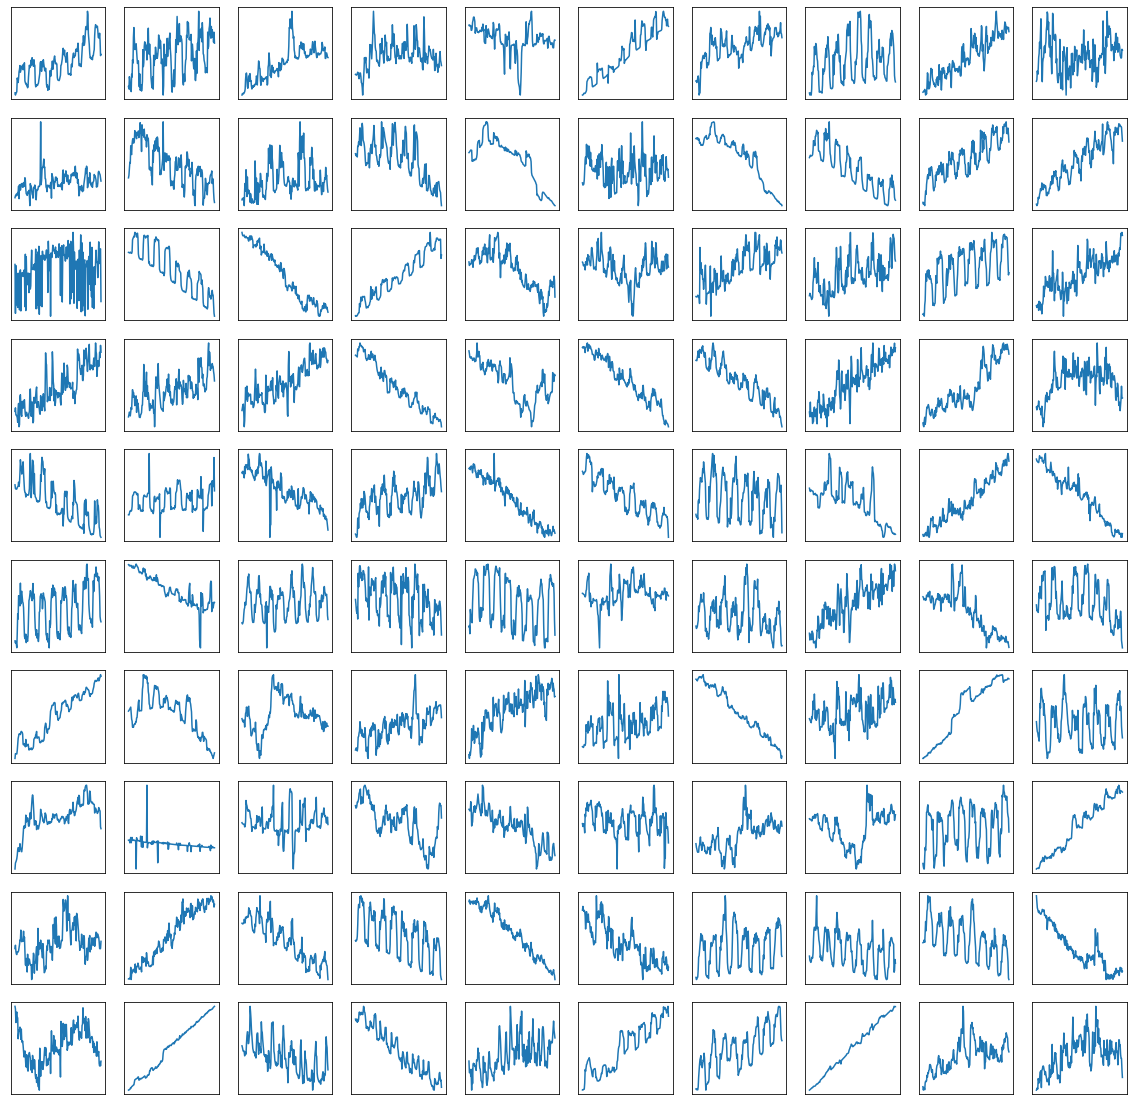

In [19]:
plot_generated_samples(generated_data)

  3%|▎         | 84/2590 [00:00<00:03, 834.10it/s]

Loading test data


100%|██████████| 2590/2590 [00:03<00:00, 823.48it/s]
2590it [00:50, 51.34it/s]
41it [00:05,  7.93it/s]


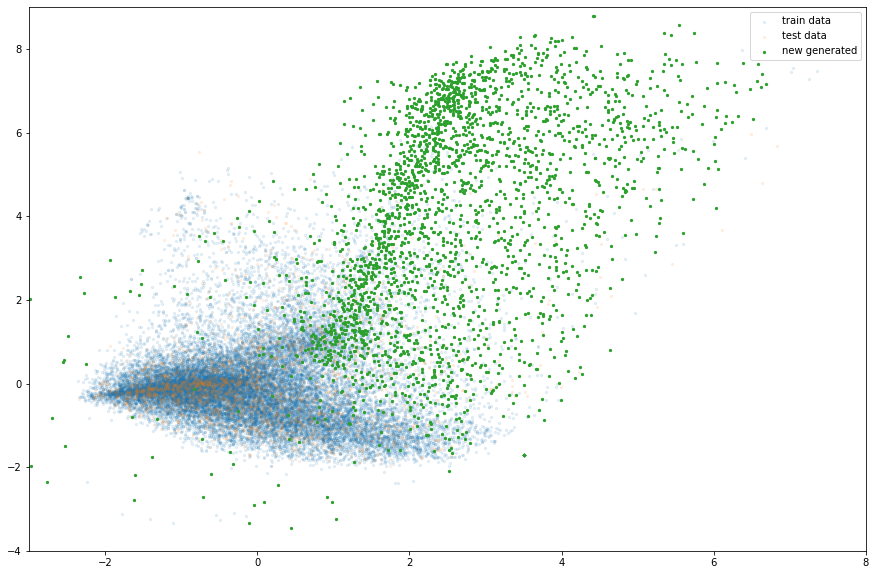

In [20]:
num_iterations = 1

sp = 24
func_args = dict(
    sp = sp,
    f_min = 5,  # trend strength
    f_max = 10,
    g = 1,  # multiplier of the trend slope 
    h_min = 0.5,  # trend lin
    h_max = 2,
    m = 0,  # slope
    k_min = 0.01,  # seasonal strength
    k_max = 0.4,
)

generated_data, generated_features, generated_metrics = sample_and_plot_pca(dataset, sp, "H", config["context_length"], config["prediction_length"], scaler, pca,
                                                                            sample_trends_and_seasonality, func_args, num_iterations)

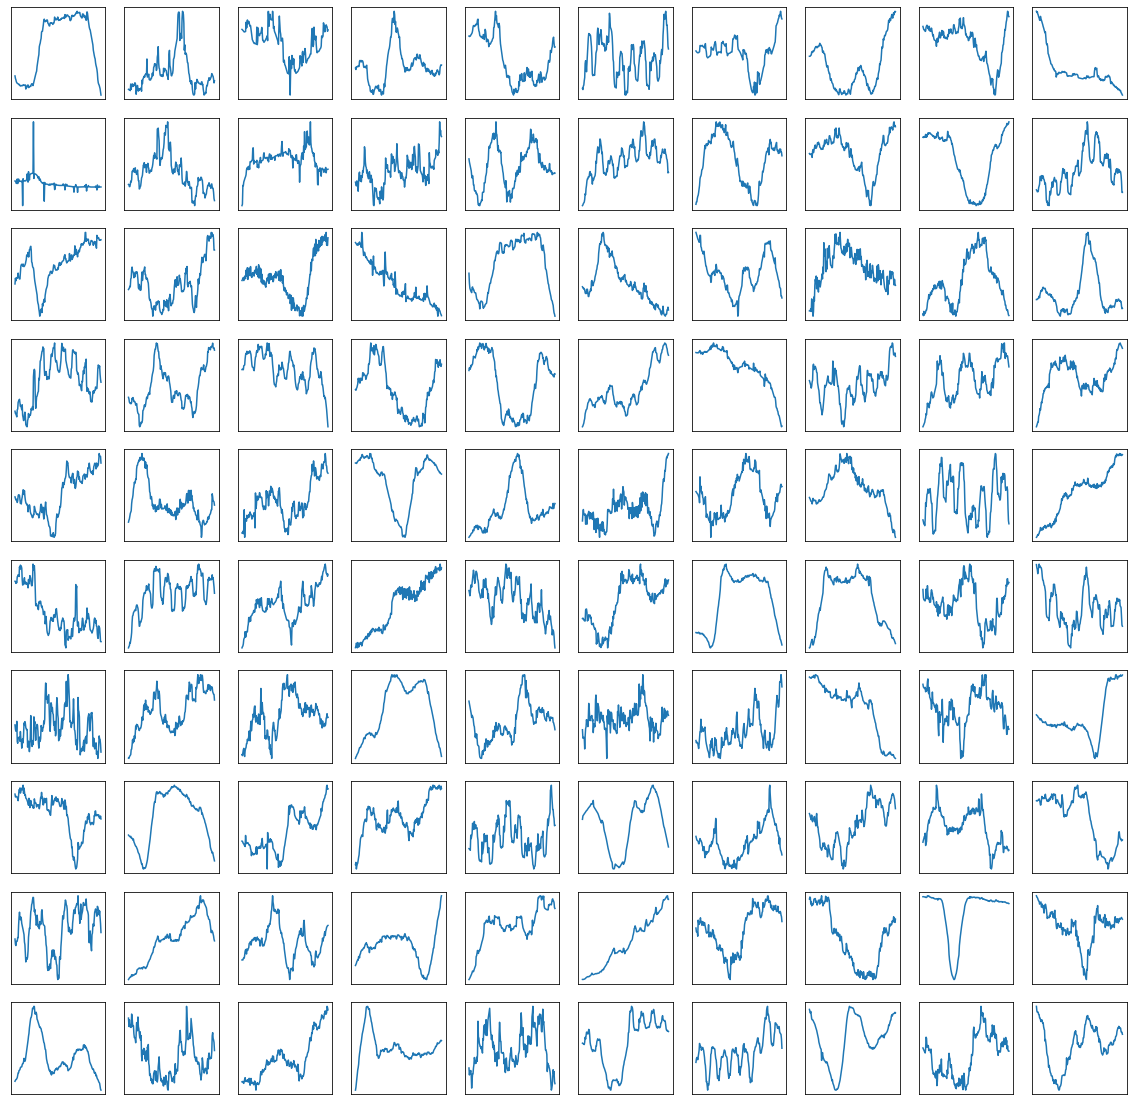

In [21]:
plot_generated_samples(generated_data)

#### Same as above, but we define a target point in PCA-space and reject samples more than some threshold away from that point

In [22]:
def sample_trends_and_seasonality_with_target(test_data, f_min, f_max, g, h_min, h_max, m, k_min, k_max, sp, scaler, pca, target, threshold):
    rng = np.random.default_rng()
    generated = []
    features = np.zeros((len(test_data), 4))
    mask = np.zeros_like(features)
    for i, ts in tqdm(enumerate(test_data)):
        decomp = STL(ts, period=sp).fit()
        
        f = rng.uniform(low=f_min, high=f_max)
        h = rng.uniform(low=h_min, high=h_max)
        k = rng.uniform(low=k_min, high=k_max)
        
        sampled_trend = manipulate_trend_component(decomp.trend, f=f, g=g, h=h, m=m)
        sampled_seasonal = manipulate_seasonal_determination(decomp.seasonal, k=k)
        new_ts = sampled_trend + sampled_seasonal + decomp.resid

        decomp = STL(new_ts, period=sp).fit()
        features[i, 0] = trend_determination(decomp.trend, decomp.resid)
        features[i, 1] = trend_slope(decomp.trend)
        features[i, 2] = trend_linearity(decomp.trend)
        features[i, 3] = seasonal_determination(decomp.seasonal, decomp.resid)
        
        scaled_features = scaler.transform(features[i].reshape([1, -1]))
        sampled_pca = pca.transform(scaled_features)
        if np.sum(np.square(sampled_pca - target)) < threshold:
            generated.append(new_ts)
            mask[i, :] = 1
    
    return generated, features[mask == 1].reshape([-1, 4])

  3%|▎         | 80/2590 [00:00<00:03, 796.33it/s]

Loading test data


100%|██████████| 2590/2590 [00:02<00:00, 886.49it/s]
2590it [00:52, 49.23it/s]
8it [00:00,  8.04it/s]


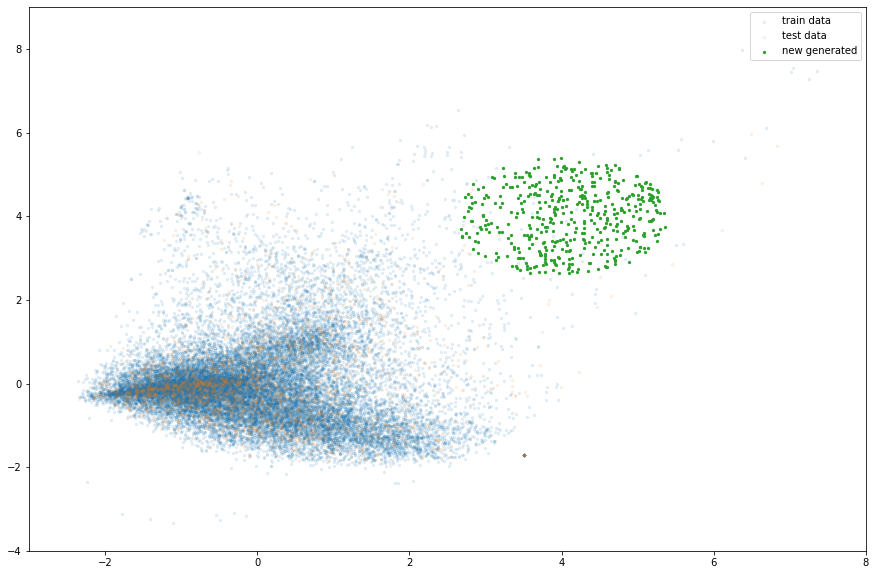

In [23]:
num_iterations = 1

sp = 24
func_args = dict(
    sp = sp,
    f_min = 5,  # trend strength
    f_max = 10,
    g = 1,  # multiplier of the trend slope 
    h_min = 5,  # trend lin
    h_max = 10,
    m = 0,  # slope
    k_min = 0.01,  # seasonal strength
    k_max = 0.4,
    scaler = scaler,
    pca = pca,
    target = np.array([4, 4]),
    threshold = 2
)

generated_data, generated_features, generated_metrics = sample_and_plot_pca(dataset, sp, "H", config["context_length"], config["prediction_length"], scaler, pca,
                                                                            sample_trends_and_seasonality_with_target, func_args, num_iterations)

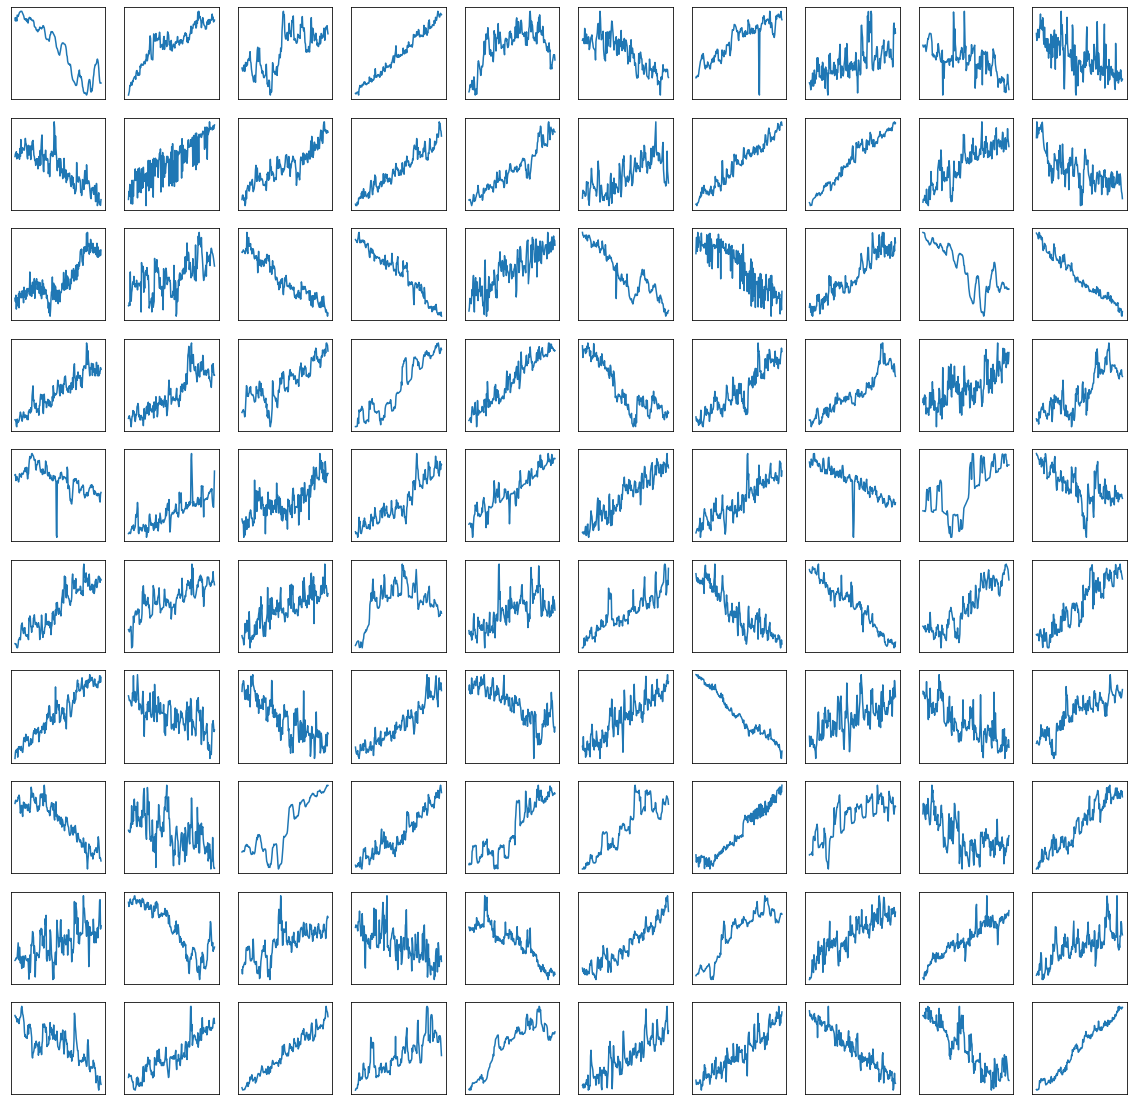

In [24]:
plot_generated_samples(generated_data)

  3%|▎         | 79/2590 [00:00<00:03, 785.76it/s]

Loading test data


100%|██████████| 2590/2590 [00:02<00:00, 900.82it/s]
2590it [00:51, 49.82it/s]
8it [00:00,  9.39it/s]


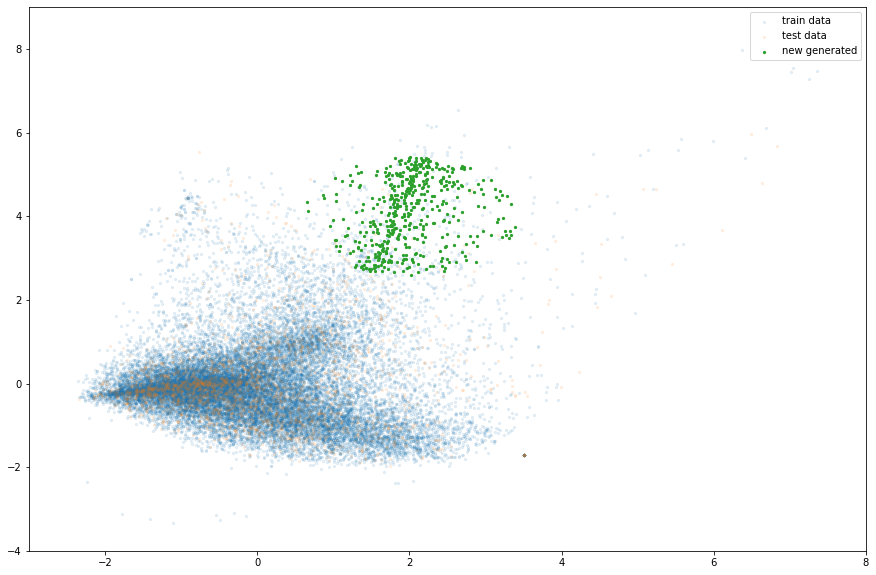

In [25]:
num_iterations = 1

sp = 24
func_args = dict(
    sp = sp,
    f_min = 5,  # trend strength
    f_max = 10,
    g = 1,  # multiplier of the trend slope 
    h_min = 0.01,  # trend lin
    h_max = 1,
    m = 0,  # slope
    k_min = 0.01,  # seasonal strength
    k_max = 0.4,
    scaler = scaler,
    pca = pca,
    target = np.array([2, 4]),
    threshold = 2
)

generated_data, generated_features, generated_metrics = sample_and_plot_pca(dataset, sp, "H", config["context_length"], config["prediction_length"], scaler, pca,
                                                                            sample_trends_and_seasonality_with_target, func_args, num_iterations)

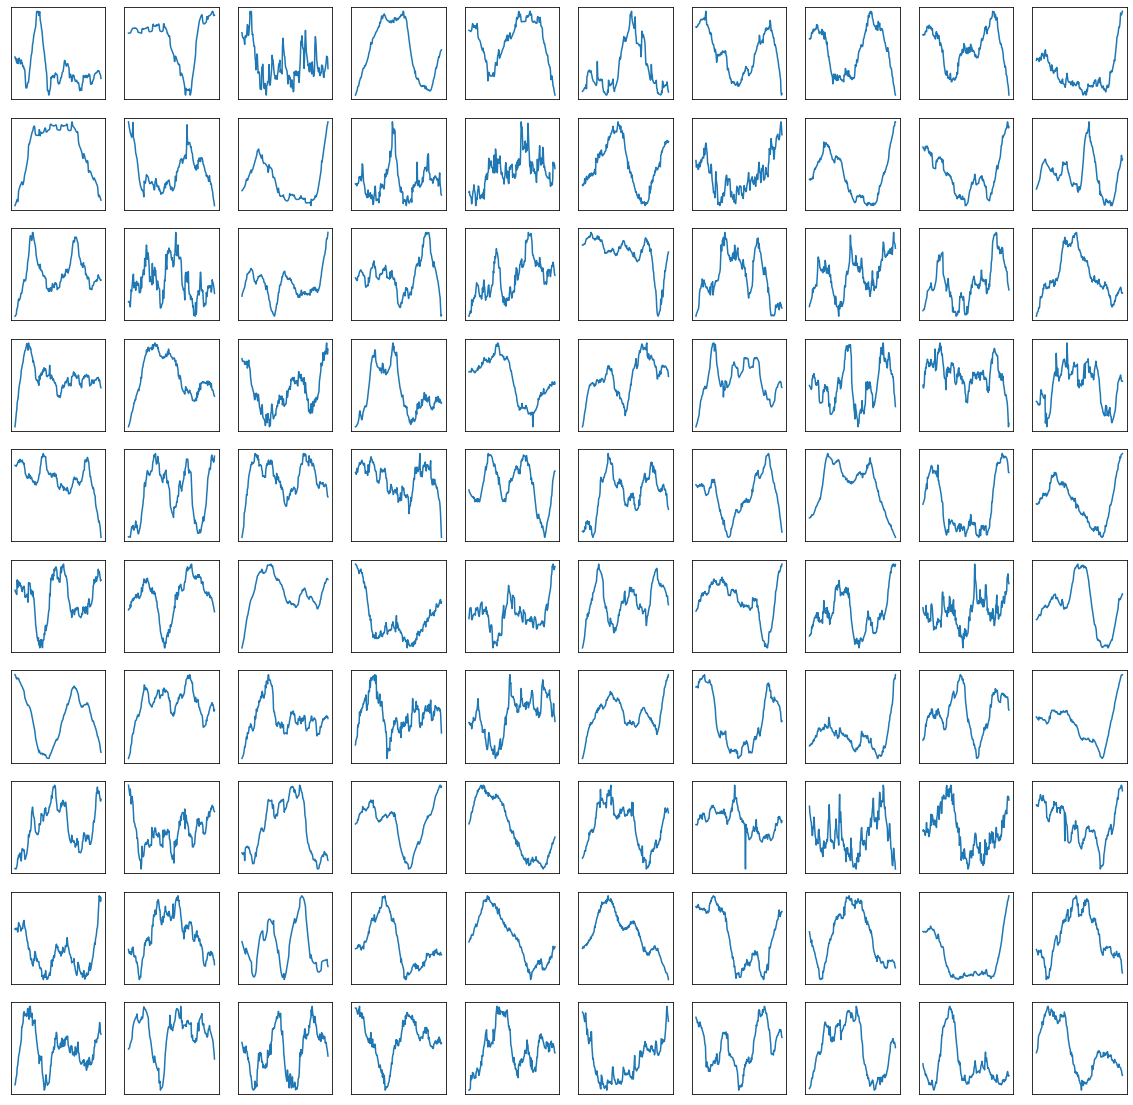

In [26]:
plot_generated_samples(generated_data)

## Embedding the original time series in the training data in the PCA-space

If we transform the original training data to a selected area and then sample from it, can we controll which where in PCA-space we sample?

370it [01:04,  5.78it/s]


(-4.0, 9.0)

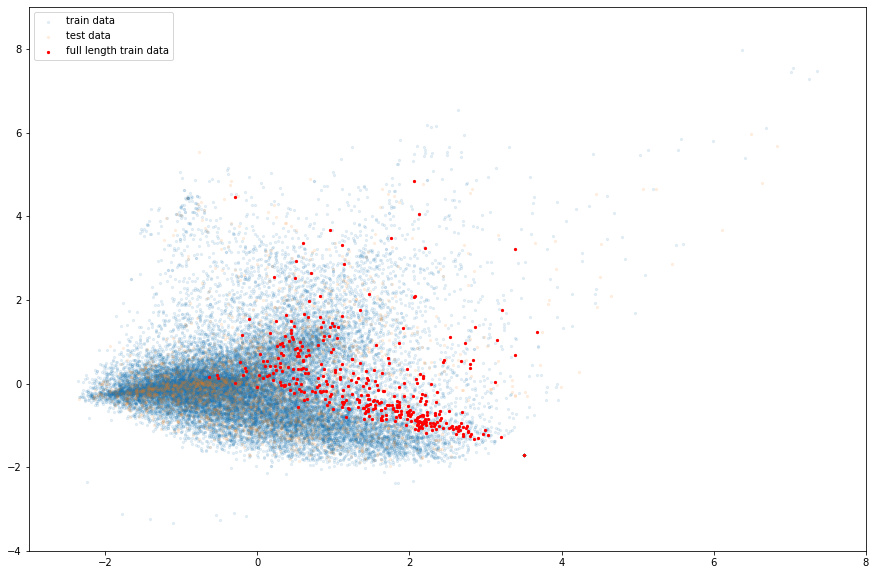

In [27]:
orig_dataset = get_dataset(dataset)
orig_dataset = ListDataset(list(iter(orig_dataset.train)), freq=orig_dataset.metadata.freq)
orig_tss = [deepcopy(ts["target"]) for ts in orig_dataset]

num_windows = 7
for i, ts in enumerate(orig_tss):
    orig_tss[i] = ts[:-config["prediction_length"] * num_windows]

_, orig_features = decomps_and_features(orig_tss, sp=24)

full_scaled_features = scaler.transform(orig_features)
full_pca_data = pca.transform(full_scaled_features)

plt.figure(figsize=(15, 10))
plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=.1)
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.1)
plt.scatter(full_pca_data[:, 0], full_pca_data[:, 1], label="full length train data", s=5, alpha=1, color="r")
plt.legend()
plt.xlim([-3, 8])
plt.ylim([-4, 9])

370it [02:09,  2.86it/s]


(-4.0, 9.0)

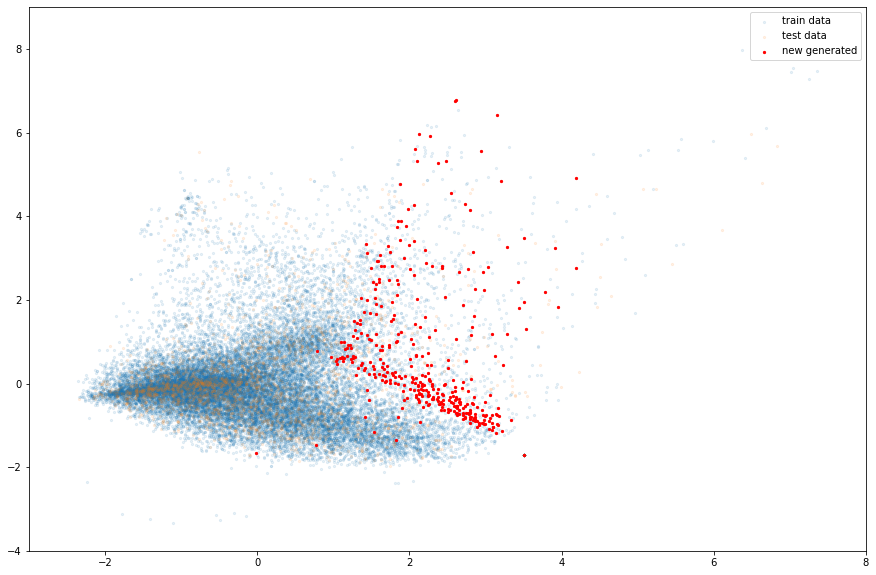

In [28]:
num_iterations = 1

sp = 24
func_args = dict(
    sp = sp,
    f_min = 4,  # trend strength
    f_max = 7,
    g = 1,  # multiplier of the trend slope 
    h_min = 0.9,  # trend lin
    h_max = 1.1,
    m = 0,  # slope
    k_min = 0.8,  # seasonal strength
    k_max = 0.95,
)

generated_data, generated_features = sample_trends_and_seasonality(orig_tss, **func_args)

norm_new_features = scaler.transform(generated_features)
new_pca_data = pca.transform(norm_new_features)

plt.figure(figsize=(15, 10))
plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=.1)
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.1)
plt.scatter(new_pca_data[:, 0], new_pca_data[:, 1], label="new generated", s=5, alpha=1, color="r")
plt.legend()
plt.xlim([-3, 8])
plt.ylim([-4, 9])

In [29]:
def sample_trends_and_seasonality_with_direction(test_data, test_pca_data, f_inc_min, f_inc_max, f_red_min, f_red_max, g, h, m,
                                                 k_inc_min, k_inc_max, k_red_min, k_red_max, sp, scaler, pca, target, threshold):
    rng = np.random.default_rng()
    generated = []
    features = np.zeros((len(test_data), 4))
    for i, ts in tqdm(enumerate(test_data)):
        decomp = STL(ts, period=sp).fit()
        
        f = 1
        if target[0] + threshold < test_pca_data[i, 1]:   
            f = rng.uniform(low=f_red_min, high=f_red_max)  # reduce
        elif test_pca_data[i, 0] < target[0] - threshold:
            f = rng.uniform(low=f_inc_min, high=f_inc_max)  # increase
        
        k = 1
        if target[1] + threshold < test_pca_data[i, 1]:
            k = rng.uniform(low=k_red_min, high=k_red_max)  # reduce
        elif test_pca_data[i, 1] < target[1] - threshold:
            k = rng.uniform(low=k_inc_min, high=k_inc_max)  # increase
        
        sampled_trend = manipulate_trend_component(decomp.trend, f=f, g=g, h=h, m=m)
        sampled_seasonal = manipulate_seasonal_determination(decomp.seasonal, k=k)
        new_ts = sampled_trend + sampled_seasonal + decomp.resid

        decomp = STL(new_ts, period=sp).fit()
        features[i, 0] = trend_determination(decomp.trend, decomp.resid)
        features[i, 1] = trend_slope(decomp.trend)
        features[i, 2] = trend_linearity(decomp.trend)
        features[i, 3] = seasonal_determination(decomp.seasonal, decomp.resid)
        
        scaled_features = scaler.transform(features[i].reshape([1, -1]))
        sampled_pca = pca.transform(scaled_features)
    
    return generated, features

In [30]:
def create_train_dataloader(dataset, context_length, prediction_length, batch_size, num_batches_per_epoch):
    transformation = Chain([
        AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        ),
        AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            pred_length=prediction_length,
            time_features=[HourOfDay(), DayOfWeek(), DayOfMonth(), DayOfYear(), MonthOfYear()]
        ),
        InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(num_instances=1, min_past=context_length,
                                                        min_future=prediction_length),
            past_length=context_length,
            future_length=prediction_length,
            time_series_fields=[FieldName.FEAT_TIME, FieldName.OBSERVED_VALUES]
        )
    ])
    dataloader = TrainDataLoader(
        generated_dataset,
        batch_size=batch_size,
        stack_fn=batchify,
        transform=transformation,
        num_batches_per_epoch=num_batches_per_epoch,
        num_workers=1
    )
    return dataloader

In [31]:
def sample_and_plot_from_dataloader(dataloader, sp, scaler, pca, train_pca_data, test_pca_data, num_samples=20000, lim=True):
    sampled_series = []
    for batch in dataloader:
        data = torch.cat([batch["past_target"], batch["future_target"]], dim=-1)
        for ts in data:
            sampled_series.append(ts)

        if len(sampled_series) > num_samples:
            break

    _, sampled_features = decomps_and_features(sampled_series, sp)
    sampled_scaled_features = scaler.transform(sampled_features)
    sampled_pca_data = pca.transform(sampled_scaled_features)

    plt.figure(figsize=(15, 10))
    
    if train_pca_data is not None:
        plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=.1)
    if test_pca_data is not None:
        plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.1)
    
    plt.scatter(sampled_pca_data[:, 0], sampled_pca_data[:, 1], label="transformed train data", s=5, alpha=.1, color="r")
    plt.legend()
    
    if lim:
        plt.xlim([-3, 8])
        plt.ylim([-4, 9])
    
    return sampled_series

In [32]:
list_data = [{"start": original["start"], "target": generated, "feat_static_cat": original["feat_static_cat"], "item_id": original["item_id"]}
             for original, generated in zip(orig_dataset, generated_data)]
generated_dataset = ListDataset(list_data, freq=orig_dataset.list_data[0]["start"].freq)

dataloader = create_train_dataloader(generated_dataset, config["context_length"], config["prediction_length"],
                                     config["trainer_args"]["batch_size"], config["trainer_args"]["num_batches_per_epoch"])

20480it [02:38, 128.84it/s]


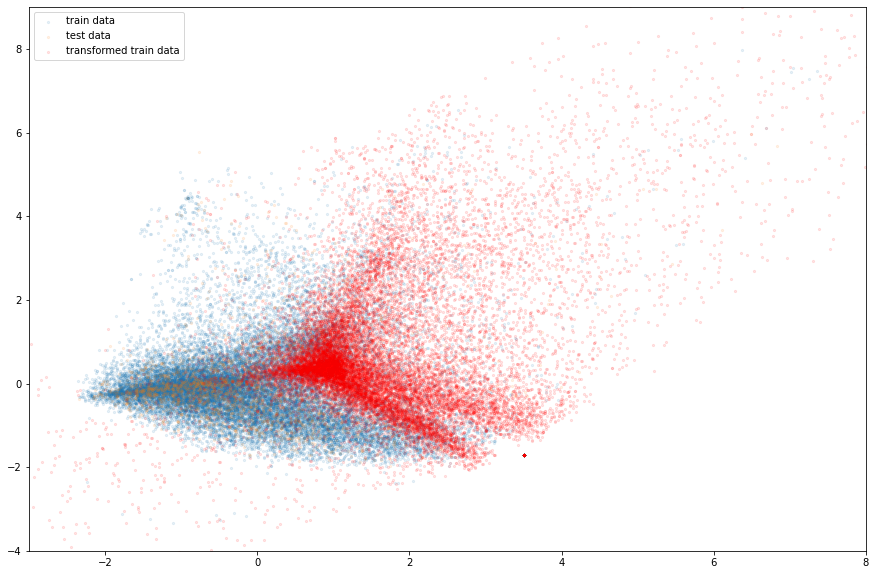

In [33]:
sampled_series = sample_and_plot_from_dataloader(dataloader, sp, scaler, pca, train_pca_data, test_pca_data)

20480it [02:38, 129.03it/s]


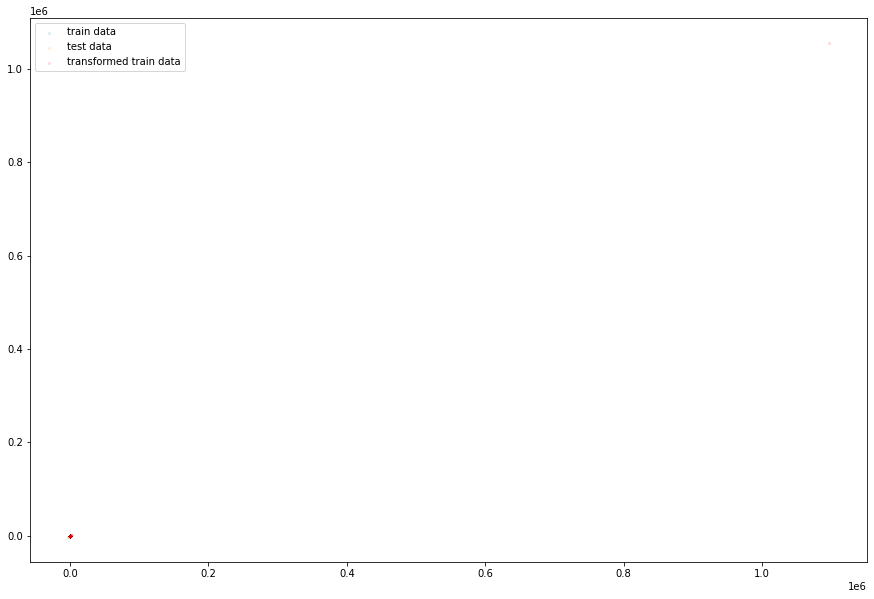

In [34]:
sampled_series = sample_and_plot_from_dataloader(dataloader, sp, scaler, pca, train_pca_data, test_pca_data, lim=False)

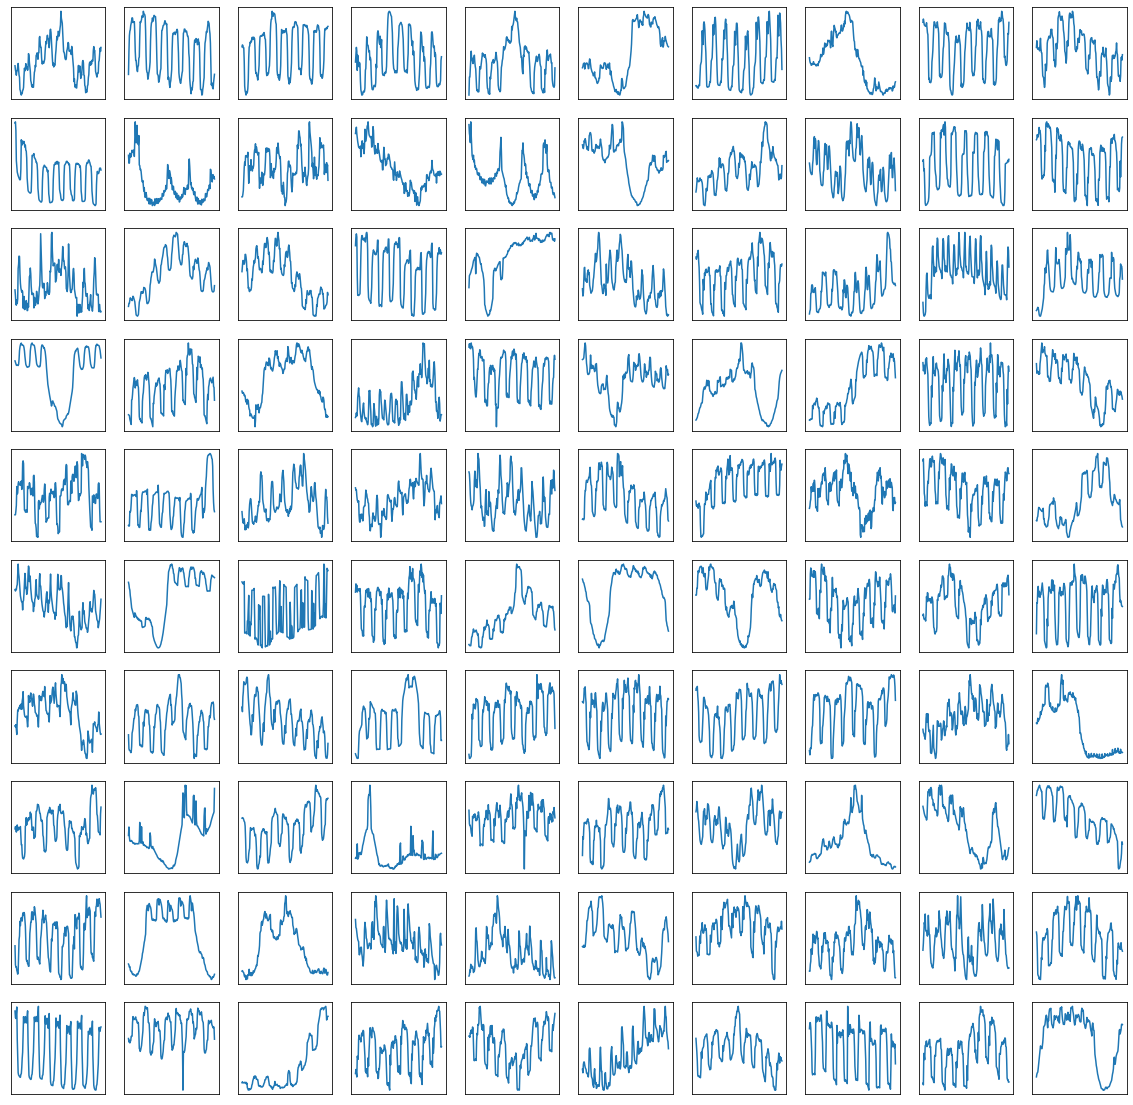

In [35]:
plot_generated_samples(sampled_series)

It looks like transforming the original, full length time series and then sampling from it allows us to control the training distribution. Interestingly, sampling intervals from the longer series results in the samples being positioned further to the left in the PCA-space. Is it possible that this is because the trend component becomes smaller in the smaller intervals?

Transforming the full training time series to a smaller area does not appear to produce samples with a distribution much different from the one seen above.

#### Merging the original and generated data into one dataloader

In [36]:
augmented_dataset = generated_dataset
augmented_dataset.list_data.extend(orig_dataset.list_data)
len(augmented_dataset.list_data)

740

In [37]:
dataloader = create_train_dataloader(augmented_dataset, config["context_length"], config["prediction_length"],
                                     config["trainer_args"]["batch_size"], config["trainer_args"]["num_batches_per_epoch"])

20480it [02:38, 129.59it/s]


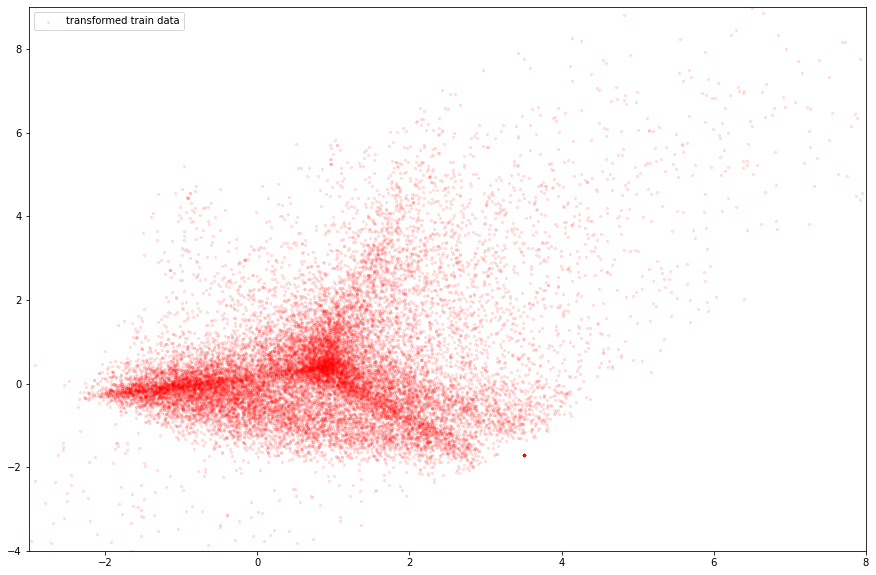

In [38]:
sampled_series = sample_and_plot_from_dataloader(dataloader, sp, scaler, pca, train_pca_data=None, test_pca_data=None)

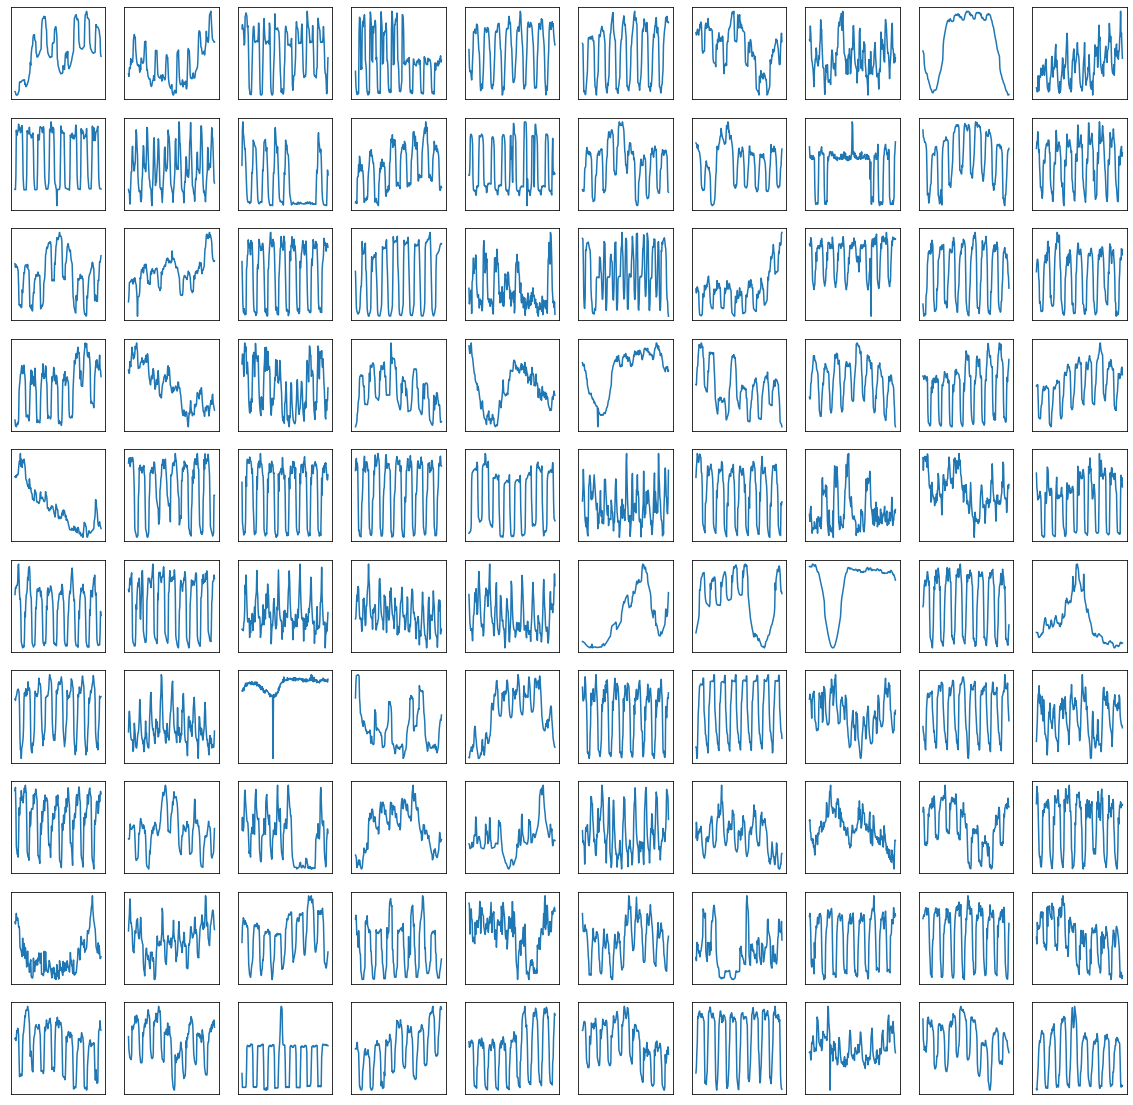

In [39]:
plot_generated_samples(sampled_series)

## Embedding test data from different time series into the same PCA-space

Where are the test data of different time series positioned in the PCA-plot? And is it possible to transform the training data enabeling sampling from the same area?

In [40]:
alt_dataset = "m4_yearly"
alt_datadir = f"data/{alt_dataset}"

(-4.0, 9.0)

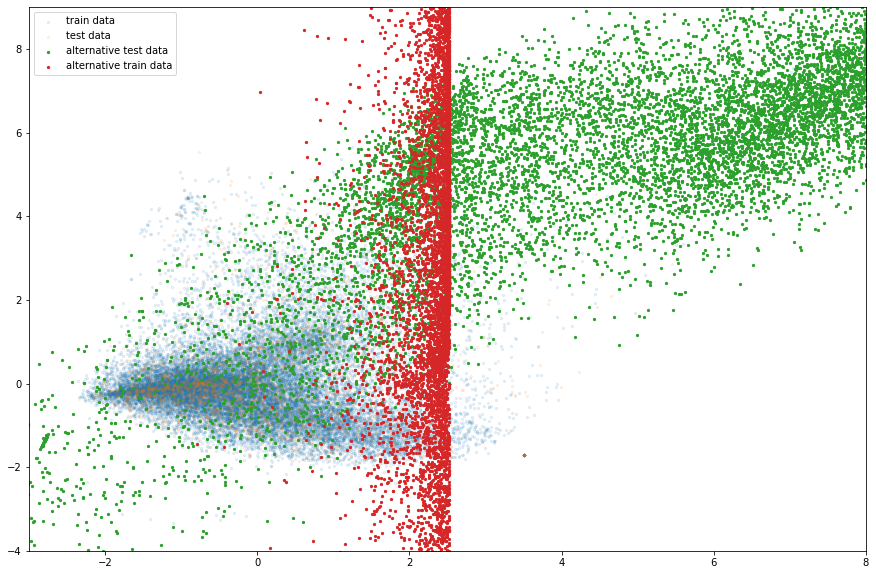

In [41]:
alt_train_features = load_features(alt_datadir, train=True)
alt_test_features = load_features(alt_datadir, train=False)

alt_scaled_train_features = scaler.transform(alt_train_features)
alt_pca_train_data = pca.transform(alt_scaled_train_features)

alt_scaled_test_features = scaler.transform(alt_test_features)
alt_pca_test_data = pca.transform(alt_scaled_test_features)


plt.figure(figsize=(15, 10))
plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=.1)
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.1)
plt.scatter(alt_pca_test_data[:, 0], alt_pca_test_data[:, 1], label="alternative test data", s=5, alpha=1)
plt.scatter(alt_scaled_train_features[:, 0], alt_scaled_train_features[:, 1], label="alternative train data", s=5, alpha=1)
plt.legend()
plt.xlim([-3, 8])
plt.ylim([-4, 9])